In [140]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import numpy as np

In [182]:
IP_COLOR, EARLY_COLOR, CONTR_COLOR, LATE_COLOR = color_palette = sns.color_palette("husl", 4)
hue_order = ["IP", "Early", "Contraction", "Late"]

In [141]:
barcode_clones = pd.read_csv("barcode_clonotypes.csv")
order_of_timepoints = {"IP": 0, "Early": 1, "Contraction": 2, "Late": 3}
barcode_clones["time_point_idx"] = barcode_clones["time_point_type"].map(order_of_timepoints)

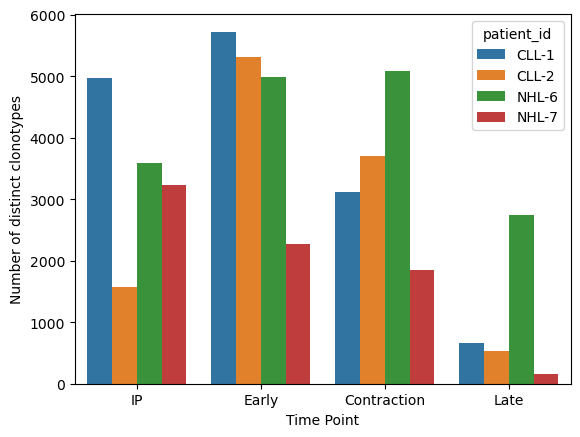

In [187]:
counts_per_timepoint = barcode_clones.groupby(["time_point_type", "patient_id"]).count().reset_index()[["cdr3", "time_point_type", "patient_id", "clone_id"]]
order_of_timepoints = {"IP": 0, "Early": 1, "Contraction": 2, "Late": 3}
counts_per_timepoint["time_point_idx"] = counts_per_timepoint["time_point_type"].map(order_of_timepoints)

sns.barplot(x="time_point_idx", y="cdr3", hue="patient_id", data=counts_per_timepoint)
plt.xticks([0, 1, 2, 3], ["IP", "Early", "Contraction", "Late"])
plt.xlabel("Time Point")
plt.ylabel("Number of distinct clonotypes")
plt.show()

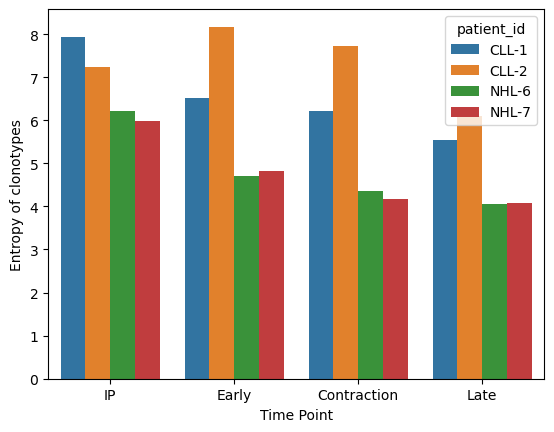

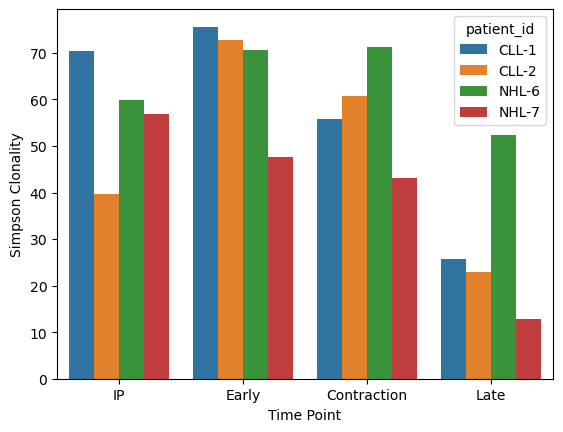

In [189]:
# Measure the entropy of the clonotypes per time point
def clonal_entropy(clone_labels):
    value,counts = np.unique(clone_labels, return_counts=True)
    return entropy(counts)

def simpson_clonality(clone_labels):
    value,counts = np.unique(clone_labels, return_counts=True)
    return np.sqrt(np.sum(np.square(counts)))

entropy_per_timepoint = barcode_clones.groupby(["time_point_type", "patient_id"]).agg({"clone_id": clonal_entropy, "barcode": simpson_clonality}).reset_index()
entropy_per_timepoint["time_point_idx"] = counts_per_timepoint["time_point_type"].map(order_of_timepoints)

sns.barplot(x="time_point_idx", y="clone_id", hue="patient_id", data=entropy_per_timepoint)
plt.xticks([0, 1, 2, 3], ["IP", "Early", "Contraction", "Late"])
plt.xlabel("Time Point")
plt.ylabel("Entropy of clonotypes")
plt.show()

sns.barplot(x="time_point_idx", y="barcode", hue="patient_id", data=entropy_per_timepoint)
plt.xticks([0, 1, 2, 3], ["IP", "Early", "Contraction", "Late"])
plt.xlabel("Time Point")
plt.ylabel("Simpson Clonality")
plt.show()


In [144]:
# look at most comomon in IP and follow them
# top_clones_in_ip = barcode_clones.query("time_point_type == 'IP'").groupby("patient_id").agg({"clone_id": lambda x: x.value_counts().index[:10]})["clone_id"].explode().values

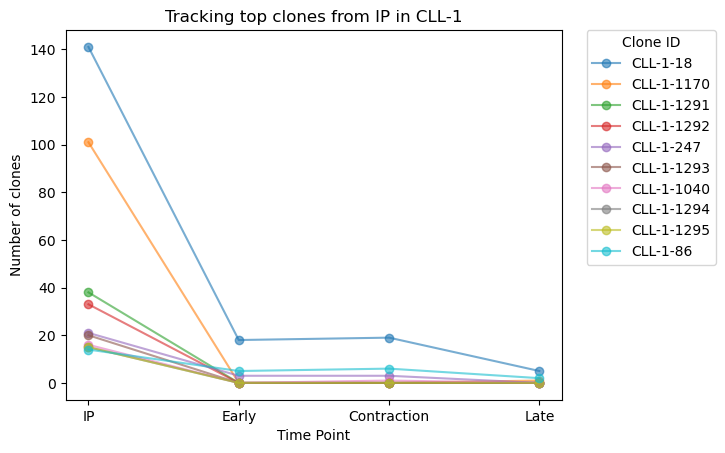

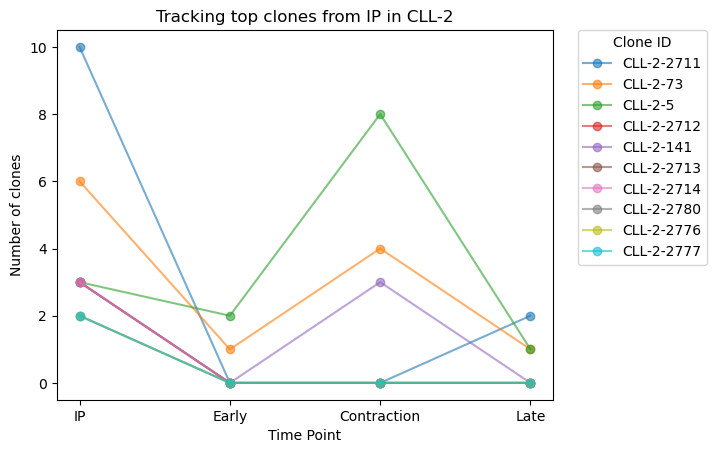

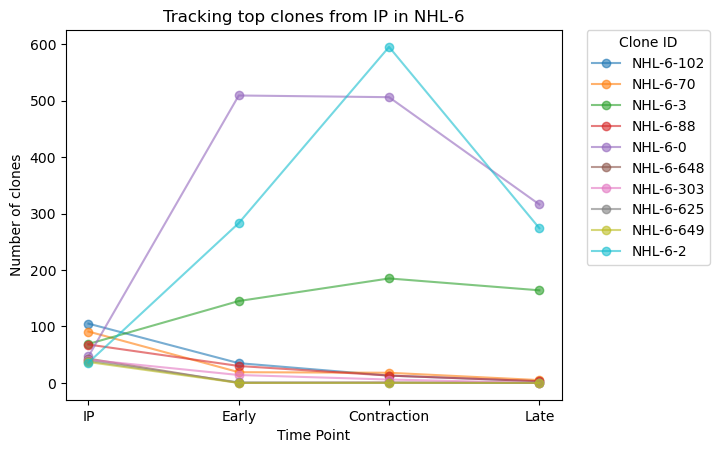

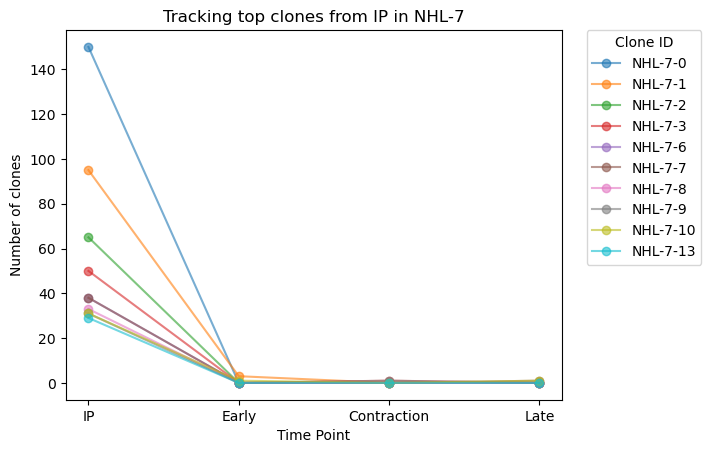

In [153]:
for patient_id, patient_group in barcode_clones.groupby("patient_id"):
    top_clones_in_ip = patient_group.query("time_point_type == 'IP'")["clone_id"].value_counts().index[:10]
    for clone in top_clones_in_ip:
        clone_df = patient_group.query("clone_id == @clone").groupby("time_point_idx").count()["clone_id"]
        for time_pt in [0,1,2,3]:
            if time_pt not in clone_df.index:
                clone_df.loc[time_pt] = 0
        plt.plot(clone_df.sort_index(), label=clone, marker="o", alpha=0.6)

    plt.xticks([0, 1, 2, 3], ["IP", "Early", "Contraction", "Late"])
    plt.xlabel("Time Point")
    plt.ylabel("Number of clones")
    plt.title(f"Tracking top clones from IP in {patient_id}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Clone ID")
    plt.show()



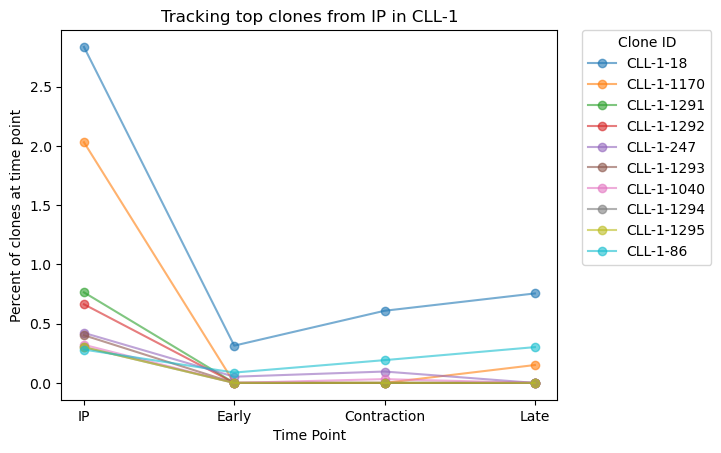

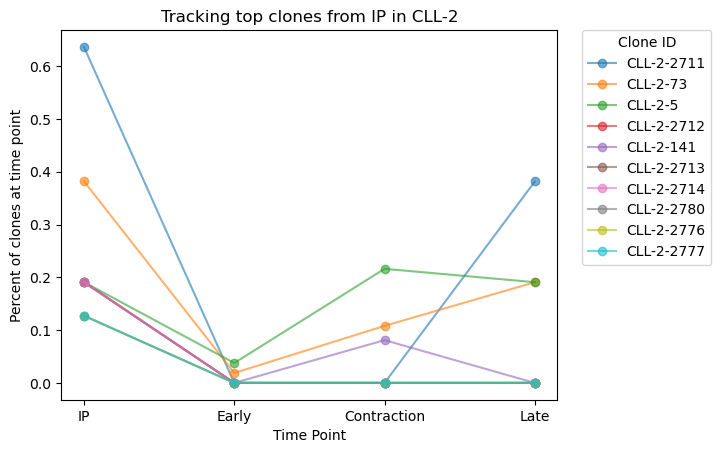

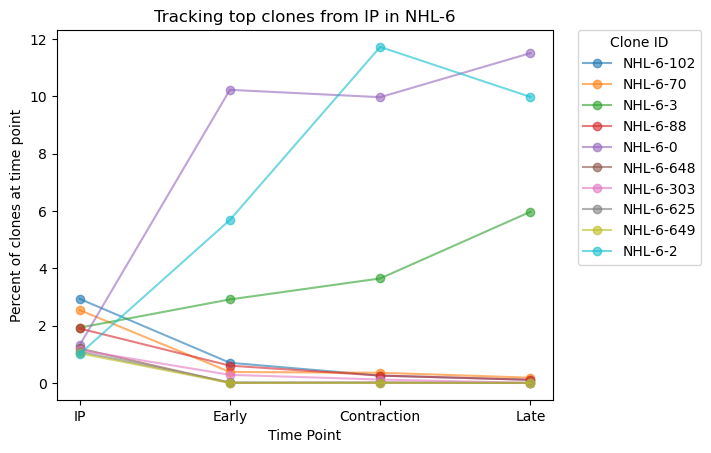

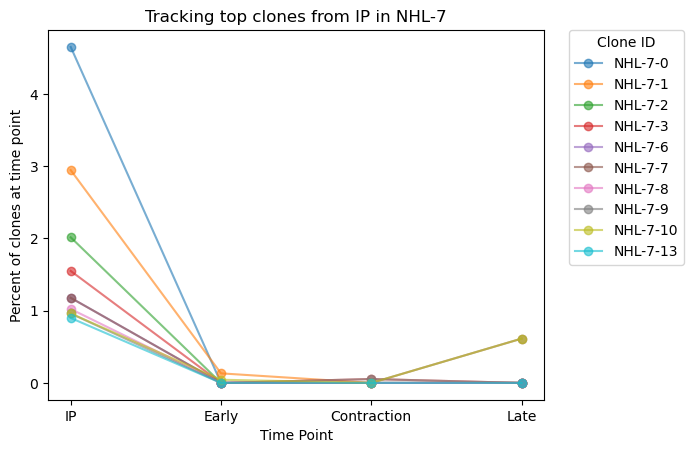

In [152]:
for patient_id, patient_group in barcode_clones.groupby("patient_id"):
    top_clones_in_ip = patient_group.query("time_point_type == 'IP'")["clone_id"].value_counts().index[:10]
    total_reads_per_timepoint = patient_group["time_point_idx"].value_counts()
    for clone in top_clones_in_ip:
        clone_df = patient_group.query("clone_id == @clone").groupby("time_point_idx").count()["clone_id"]
        for time_pt in [0,1,2,3]:
            if time_pt not in clone_df.index:
                clone_df.loc[time_pt] = 0
            else:
                clone_df.loc[time_pt] = (clone_df.loc[time_pt] / total_reads_per_timepoint.loc[time_pt]) * 100
        plt.plot(clone_df.sort_index(), label=clone, marker="o", alpha=0.6)

    plt.xticks([0, 1, 2, 3], ["IP", "Early", "Contraction", "Late"])
    plt.xlabel("Time Point")
    plt.ylabel("Percent of clones at time point")
    plt.title(f"Tracking top clones from IP in {patient_id}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Clone ID")
    plt.show()



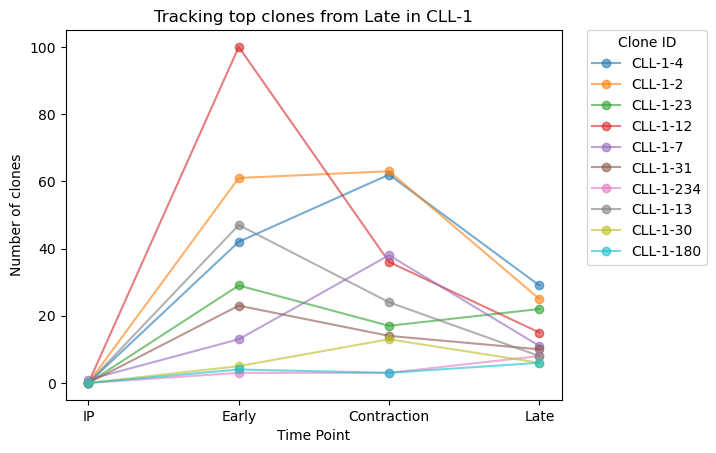

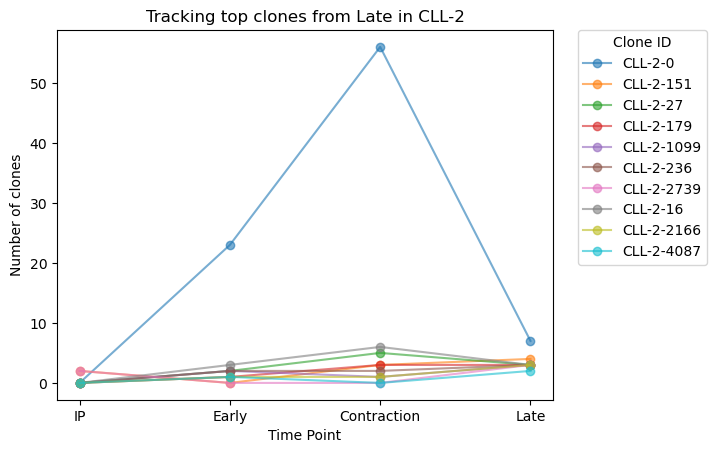

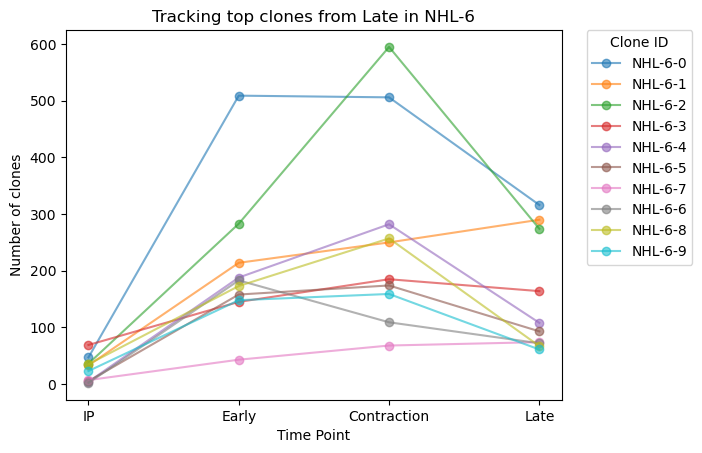

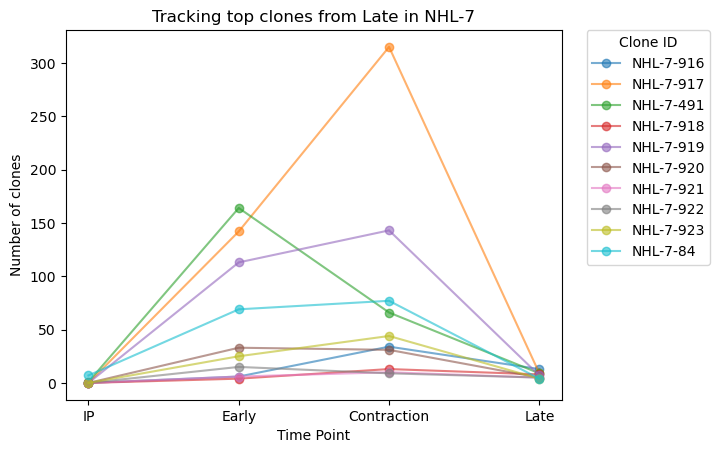

In [151]:
# look into top clones at late time point and see where they came from
for patient_id, patient_group in barcode_clones.groupby("patient_id"):
    top_clones_in_ip = patient_group.query("time_point_type == 'Late'")["clone_id"].value_counts().index[:10]
    for clone in top_clones_in_ip:
        clone_df = patient_group.query("clone_id == @clone").groupby("time_point_idx").count()["clone_id"]
        for time_pt in [0,1,2,3]:
            if time_pt not in clone_df.index:
                clone_df.loc[time_pt] = 0
        plt.plot(clone_df.sort_index(), label=clone, marker="o", alpha=0.6)

    plt.xticks([0, 1, 2, 3], ["IP", "Early", "Contraction", "Late"])
    plt.xlabel("Time Point")
    plt.ylabel("Number of clones")
    plt.title(f"Tracking top clones from Late in {patient_id}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Clone ID")
    plt.show()



### A version of the clone tracking plots that includes both IP and late timepoints

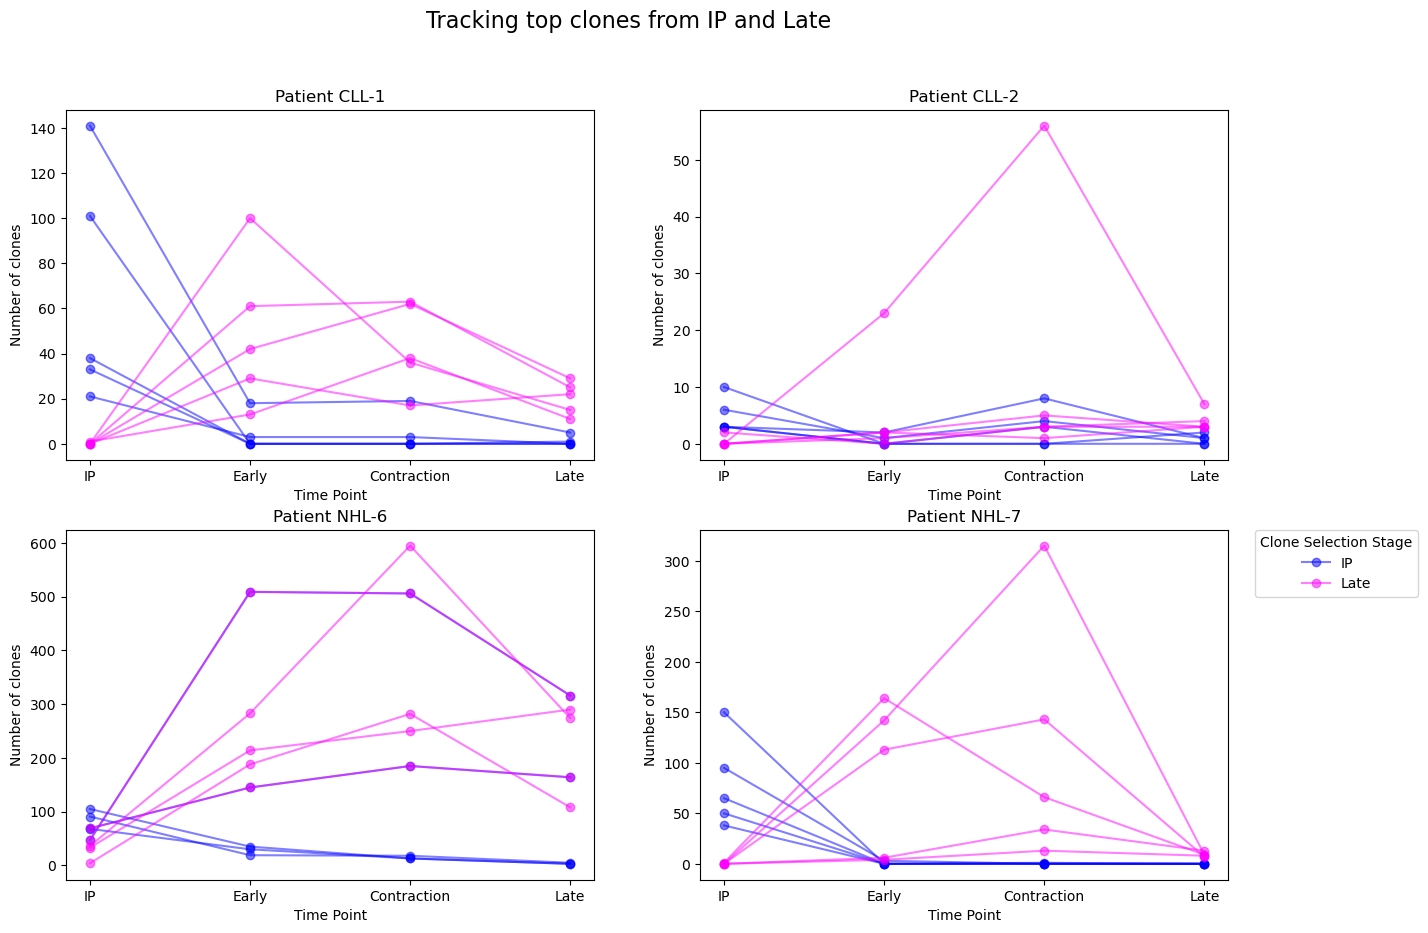

In [190]:
# make figure with 4 plots and one shared legend
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# set title for whole plot
fig.suptitle("Tracking top clones from IP and Late", fontsize=16)

for i, (patient_id, patient_group) in enumerate(barcode_clones.groupby("patient_id")):
    top_clones_in_ip = patient_group.query("time_point_type == 'IP'")["clone_id"].value_counts().index[:5]
    top_clones_in_late = patient_group.query("time_point_type == 'Late'")["clone_id"].value_counts().index[:5]
    for state, clone in zip(["IP"]*5+["Late"]*5, list(top_clones_in_ip) + list(top_clones_in_late)):
        clone_df = patient_group.query("clone_id == @clone").groupby("time_point_idx").count()["clone_id"]
        for time_pt in [0,1,2,3]:
            if time_pt not in clone_df.index:
                clone_df.loc[time_pt] = 0
        axs[i].plot(clone_df.sort_index(), label=state, marker="o", alpha=0.5, color="blue" if state == "IP" else "magenta")

    axs[i].set_xticks([0, 1, 2, 3], ["IP", "Early", "Contraction", "Late"])
    axs[i].set_xlabel("Time Point")
    axs[i].set_ylabel("Number of clones")
    axs[i].set_title(f"Patient {patient_id}")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Clone Selection Stage")
plt.show()



## Look into which clones expand and contract at different time points

In [298]:
clone_counts = barcode_clones.groupby(["clone_id", "time_point_type"]).count()["cdr3"].unstack().fillna(0)[["IP", "Early", "Contraction", "Late"]]
epsilon = 0.0001
clone_counts["early_expansion"] = clone_counts["Early"] / (clone_counts["IP"] + epsilon)
clone_counts["contraction_expansion"] = clone_counts["Contraction"] / (clone_counts["Early"] + epsilon)
clone_counts["late_expansion"] = clone_counts["Late"] / (clone_counts["Contraction"] + epsilon)
clone_counts["patient_id"] = ["-".join(id.split("-")[:-1]) for id in clone_counts.index]

clone_counts["early_to_late_expansion"] = clone_counts["late_expansion"] / (clone_counts["early_expansion"] + epsilon)

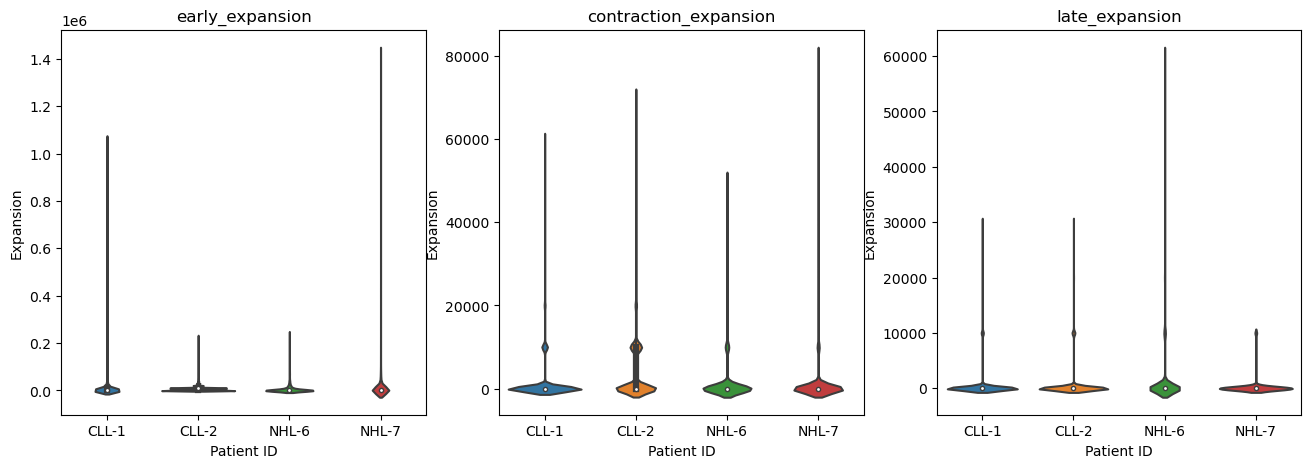

In [270]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs = axs.flatten()

for i, col in enumerate(["early_expansion", "contraction_expansion", "late_expansion"]):
    sns.violinplot(data=clone_counts, x="patient_id", y=col, ax=axs[i])
    axs[i].set_title(f"{col}")
    axs[i].set_xlabel("Patient ID")
    axs[i].set_ylabel("Expansion")

plt.show()


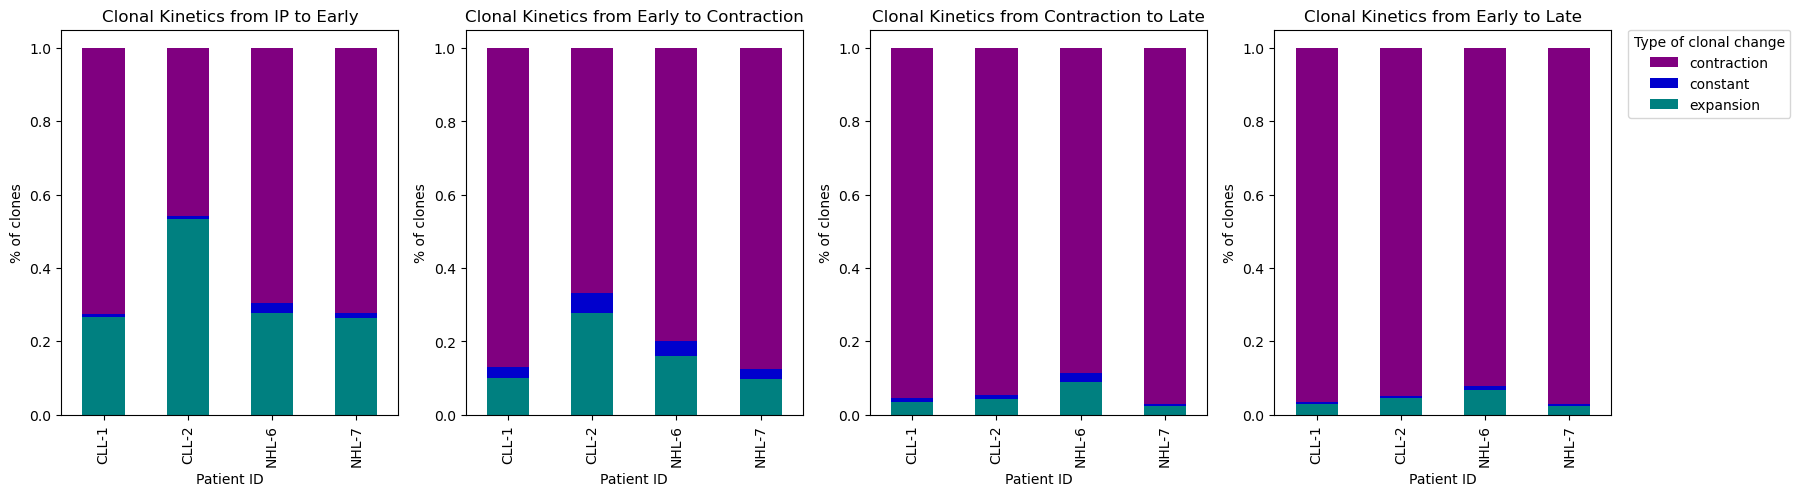

In [301]:
plot_titles = ["IP to Early", "Early to Contraction", "Contraction to Late", "Early to Late"]
fig, axs = plt.subplots(1, len(plot_titles), figsize=(len(plot_titles)*5, 5))
axs = axs.flatten()




for i, col in enumerate(["early_expansion", "contraction_expansion", "late_expansion", "early_to_late_expansion"]):
    clone_copy = clone_counts.copy()
    clone_copy["expansion"] = clone_copy[col] > 1.1
    clone_copy["contraction"] = clone_copy[col] < 0.9
    clone_copy["constant"] = (clone_copy[col] <= 1.1) & (clone_copy[col] >= 0.9)
    clone_copy.groupby("patient_id").mean()[["expansion", "constant", "contraction"]].plot(kind="bar", stacked=True, ax=axs[i], legend=False, color=["teal", "mediumblue", "purple"])
    axs[i].set_title(f"Clonal Kinetics from {plot_titles[i]}")
    axs[i].set_xlabel("Patient ID")
    axs[i].set_ylabel("% of clones")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(list(by_label.values())[::-1], list(by_label.keys())[::-1], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Type of clonal change")

plt.show()

In [303]:
# Create lists of, for each time point, and for each patient, which clones expanded and which contracted
for i, col in enumerate(["early_expansion", "contraction_expansion", "late_expansion", "early_to_late_expansion"]):
    clone_copy = clone_counts.copy()
    clone_copy["expansion"] = clone_copy[col] > 1.1
    clone_copy["contraction"] = clone_copy[col] < 0.9
    clone_copy["constant"] = (clone_copy[col] <= 1.1) & (clone_copy[col] >= 0.9)

In [304]:
clone_copy

time_point_type,IP,Early,Contraction,Late,early_expansion,contraction_expansion,late_expansion,patient_id,early_to_late_expansion,expansion,contraction,constant
clone_id,,,,,,,,,,,,
CLL-1-0,0.0,23.0,70.0,2.0,230000.0,3.043465,0.028571,CLL-1,1.242234e-07,False,True,False
CLL-1-1,0.0,106.0,65.0,2.0,1060000.0,0.613207,0.030769,CLL-1,2.902753e-08,False,True,False
CLL-1-10,0.0,41.0,37.0,1.0,410000.0,0.902437,0.027027,CLL-1,6.591940e-08,False,True,False
CLL-1-100,0.0,53.0,6.0,0.0,530000.0,0.113207,0.000000,CLL-1,0.000000e+00,False,True,False
CLL-1-1000,0.0,0.0,1.0,0.0,0.0,10000.000000,0.000000,CLL-1,0.000000e+00,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
NHL-7-995,0.0,11.0,18.0,0.0,110000.0,1.636349,0.000000,NHL-7,0.000000e+00,False,True,False
NHL-7-996,0.0,8.0,0.0,0.0,80000.0,0.000000,0.000000,NHL-7,0.000000e+00,False,True,False
NHL-7-997,0.0,10.0,0.0,0.0,100000.0,0.000000,0.000000,NHL-7,0.000000e+00,False,True,False


In [271]:
# get list of clones that are in the top 10% of expansion in each time point
top_early_clones = clone_counts.query("early_expansion > @clone_counts.early_expansion.quantile(0.9)").index
top_contraction_clones = clone_counts.query("contraction_expansion > @clone_counts.contraction_expansion.quantile(0.9)").index
top_late_clones = clone_counts.query("late_expansion > @clone_counts.late_expansion.quantile(0.9)").index

bottom_early_clones = clone_counts.query("early_expansion < @clone_counts.early_expansion.quantile(0.1)").index
bottom_contraction_clones = clone_counts.query("contraction_expansion < @clone_counts.contraction_expansion.quantile(0.1)").index
bottom_late_clones = clone_counts.query("late_expansion < @clone_counts.late_expansion.quantile(0.1)").index